In [27]:


import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score   



In [2]:
df = pd.read_csv("https://project-2-rice.s3.us-east-2.amazonaws.com/sp500_adj_close_raw.csv")


In [3]:
# Check for missing values
df_na  = df.isna().sum()
print(df_na)

Date              0
Ticker            0
Adjusted Close    0
Return            0
Volatility        0
RSI               0
SMA_50            0
SMA_100           0
SMA_200           0
Upper Band        0
Lower Band        0
Support           0
Resistance        0
Action            0
dtype: int64


In [4]:
# Filling missing values with the mean of the column 
# df.fillna(df.mean(), inplace=True)
# Takes a long time to run! We don't have NaN so you can skip this step

Dropping the "Ticker" column is generally a good choice for predicting the SMA_200 rolling average.

Here's why:

Redundancy: The "Ticker" column is essentially a categorical identifier for each stock. It doesn't directly contribute to the prediction of the SMA_200, which is a numerical value based on historical stock prices.
Overfitting: Including the "Ticker" as a feature could potentially lead to overfitting, especially if the model learns to associate specific tickers with particular SMA_200 values. This might not generalize well to new, unseen tickers.
Computational efficiency: Dropping the "Ticker" column can reduce the dimensionality of the feature space, leading to faster training and prediction times.

In [5]:
# Drop the 'Ticker' column from the dataframe
df = df.drop(columns=['Ticker'])

In [6]:
# One-hot encode the 'Action' column
df = pd.get_dummies(df, columns=['Action'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979679 entries, 0 to 1979678
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Date            object 
 1   Adjusted Close  float64
 2   Return          float64
 3   Volatility      float64
 4   RSI             float64
 5   SMA_50          float64
 6   SMA_100         float64
 7   SMA_200         float64
 8   Upper Band      float64
 9   Lower Band      float64
 10  Support         float64
 11  Resistance      float64
 12  Action_buy      bool   
 13  Action_hold     bool   
 14  Action_sell     bool   
 15  Action_short    bool   
dtypes: bool(4), float64(11), object(1)
memory usage: 188.8+ MB


In [8]:
# Label Encodign is not the best method to encode the 'Action' column
# Label Encoding Result:
# Red -> 0
# Green -> 1
# Blue -> 2

# le = LabelEncoder()
# df['Action_encoded'] = le.fit_transform(df['Action'])

In [9]:
# Chosing features for predictiors
X = df[['Adjusted Close', 'Return','Volatility', 'RSI', 'SMA_50', 'SMA_100', 'Upper Band', 'Lower Band', 'Support', 'Resistance', 'Action_buy', 'Action_sell']]



In [10]:
print(df['SMA_200'].head()) # Target variable

0    23.564934
1     4.197630
2    17.709028
3     7.874161
4    28.471031
Name: SMA_200, dtype: float64


In [11]:
kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
y = kbins.fit_transform(df[['SMA_200']]).astype(int).ravel()

/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [12]:
# Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# Random Forest Calssifier 
rf_model = RandomForestClassifier(random_state=42)

In [14]:
# Define the parameter grid 
param_gird= {
    'n_estimators' : [100, 200, 300, 400, 500],
    'max_depth' : [None, 10, 20, 30, 40, 50],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4]
}

In [15]:
# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_gird, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.0min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.0min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.0min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.1min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.1min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.0min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.0min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.0min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.1min
[CV] END 

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 400, 500]},
             verbose=2)

In [17]:
# Get the best parameters
best_params = grid_search.best_params_
# Get the best score
best_score = grid_search.best_score_
print(f'Best score: {best_score}')
print(f'Best parameters: {best_params}')


Best score: 0.9999943172570172
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [20]:
# Train the model with the best parameters
best_rf = rf_model.set_params(**best_params)
best_rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=300, random_state=42)

In [21]:
# Evaluate the model 
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'accuracy: {accuracy}')

accuracy: 0.9999974743392872


In [25]:
import pickle

# Save the model to a file
with open('Random_Forest_200rd.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

In [26]:

# Load the model from the file
with open('Random_Forest_200rd.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
# Use the loaded model to make predictions
predictions = loaded_model.predict(X_test)


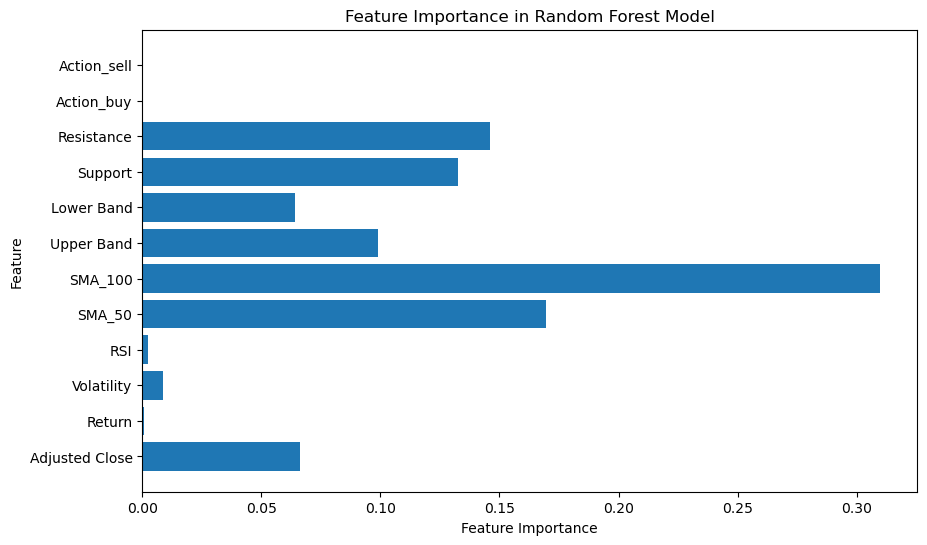

In [28]:
# Understanding the feature importance 
importances = best_rf.feature_importances_
feature_names = X_train.columns 
# Plotting the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.show()